In [2]:
import os  
import sys  
import glob  
  
import numpy as np  
import pandas as pd  
import json
  
import matplotlib.pylab as plt  
from matplotlib_venn import venn2  
import seaborn as sns  

import scorecardpy as sc
  
from tqdm import tqdm  
from itertools import cycle  

  
from sklearn import metrics  
from sklearn import model_selection  
from sklearn import preprocessing  
from sklearn import linear_model  
from sklearn import feature_selection

  
pd.set_option("display.max_columns", None)  
  
plt.style.use("ggplot")  
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]  
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])  

In [2]:
%%time  
train_dataframe = pd.read_feather('train.feather')  
test_dataframe = pd.read_feather('test.feather')  
train_labels = pd.read_csv("train_labels.csv")  
train_dataframe.shape, test_dataframe.shape  

CPU times: total: 57.8 s
Wall time: 25.9 s


((5531451, 190), (11363762, 190))

In [3]:
train_dataframe.head()  

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,NaN,NaN,0.000630,0.080994,0.708984,0.170654,0.006203,0.358643,0.525391,0.255615,NaN,0.063904,0.059418,0.006466,0.148682,1.335938,0.008209,0.001423,0.207275,0.736328,0.096191,NaN,0.023376,0.002768,0.008324,1.001953,0.008301,0.161377,0.148315,0.922852,0.354492,0.151978,0.118103,0.001882,0.158569,0.065735,0.018387,0.063660,0.199585,0.308350,0.016357,0.401611,0.091064,0,1,0.007126,0.007664,NaN,0.652832,0.008522,-1,0.004730,6,0.271973,0.008362,0.515137,0.002644,0.009010,0.004807,0.008339,0.119385,0.004803,0.108276,0.050873,NaN,0.007553,0.080444,0.069092,NaN,0.004326,0.007561,NaN,0.007729,0.000272,0.001575,0.004238,0.001434,NaN,0.002272,0.004059,0.007122,0.002457,0.002310,0.003532,0.506836,0.008034,1.009766,0.084656,0.003820,0.007042,0.000438,0.006451,0.000830,0.005054,NaN,0,0.005722,0.007084,NaN,0.000198,0.008911,NaN,1.0,0.002537,0.005177,0.006626,0.009705,0.007782,0.002449,1.000977,0.002665,0.007481,0.006893,1.503906,1.005859,0.003569,0.008873,0.003948,0.003647,0.004951,0.894043,0.135620,0.911133,0.974609,0.001244,0.766602,1.008789,1.004883,0.893555,NaN,0.669922,0.009972,0.004570,NaN,1.008789,2,NaN,0.004326,NaN,NaN,NaN,1.007812,0.210083,0.676758,0.007874,1,0.238281,0,4,0.232178,0.236206,0,0.702148,0.434326,0.003057,0.686523,0.008743,1,1.002930,1.007812,1.000000,0.006805,NaN,0.002052,0.005970,NaN,0.004345,0.001534,NaN,NaN,NaN,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,NaN,NaN,0.002525,0.069397,0.712891,0.113220,0.006207,0.353516,0.521484,0.223389,NaN,0.065247,0.057739,0.001614,0.149780,1.339844,0.008369,0.001984,0.202759,0.720703,0.099792,NaN,0.030594,0.002748,0.002481,1.008789,0.005135,0.140991,0.143555,0.919434,0.326660,0.156250,0.118713,0.001610,0.148438,0.093933,0.013039,0.065491,0.151367,0.265137,0.017685,0.406250,0.086792,0,1,0.002413,0.007149,NaN,0.646973,0.002237,-1,0.003880,6,0.188965,0.004028,0.509277,0.004192,0.007843,0.001283,0.006523,0.140625,0.000094,0.101013,0.040466,NaN,0.004833,0.081421,0.074158,NaN,0.004204,0.005302,NaN,0.001864,0.000978,0.009895,0.007599,0.000509,NaN,0.009811,0.000126,0.005966,0.000395,0.001327,0.007774,0.500977,0.000761,1.009766,0.081848,0.000347,0.007790,0.004311,0.002333,0.009468,0.003754,NaN,0,0.007584,0.006676,NaN,0.001143,0.005905,NaN,1.0,0.008430,0.008980,0.001854,0.009926,0.005989,0.002247,1.006836,0.002508,0.006828,0.002836,1.503906,1.005859,0.000571,0.000391,0.008354,0.008850,0.003180,0.902344,0.136353,0.919922,0.975586,0.004562,0.786133,1.000000,1.003906,0.906738,NaN,0.668457,0.003922,0.004654,NaN,1.002930,2,NaN,0.008705,NaN,NaN,NaN,1.007812,0.184082,0.822266,0.003445,1,0.247192,0,4,0.243530,0.241943,0,0.707031,0.430420,0.001306,0.686523,0.000755,1,1.008789,1.003906,1.008789,0.004406,NaN,0.001034,0.004837,NaN,0.007496,0.004932,NaN,NaN,NaN,NaN,

In [4]:
train_labels.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


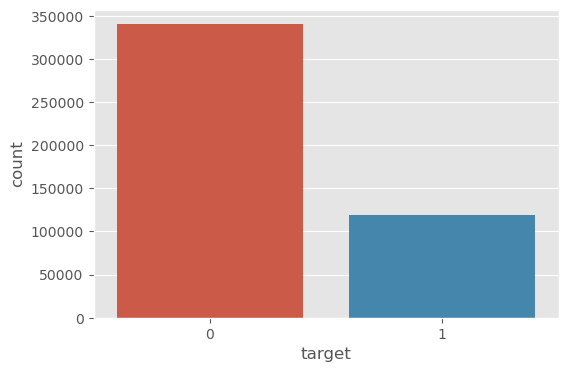

In [5]:
fig, ax = plt.subplots(figsize=(6,4))  
sns.countplot(x=train_labels.target)  
plt.show()  

In [6]:
train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: float16(177), int8(11), object(2)
memory usage: 2.0+ GB


In [7]:
#Convert S_2 to Time Format
train_dataframe['S_2'] = pd.to_datetime(train_dataframe['S_2'])  
train_dataframe['S_2'].min(), train_dataframe['S_2'].max()  

(Timestamp('2017-03-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

### FEATURE SELECTION

In [8]:
#The code is effectively reducing both the training and test datasets to only the most recent data entries for each customer. This is a common preprocessing step when building models that predict outcomes based on the latest available data. The assumption is that the most recent features are the most relevant for predicting current or future customer behavior.


# Training data preparation  
# taking the latest profile features for each customer  
  
train_dataframe = train_dataframe.groupby("customer_ID").tail(1).reset_index(drop=True)  
test_dataframe = test_dataframe.groupby("customer_ID").tail(1).reset_index(drop=True)  
  
# Merge with targets  
train_dataframe = train_dataframe.merge(train_labels, on='customer_ID', how='left')  
  
target_col = 'target'  ## this is target column
drop_cols = ['customer_ID', 'S_2', target_col]  ## these are source columns on which we wamt the result and it will beexcluded from train dataset 
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']  ##these are main categorical vars
train_cols = [col for col in train_dataframe.columns if col not in drop_cols]  ##all cols except the drop cols


In [9]:
for cols in train_cols:
    if cols in cat_cols:
        train_dataframe[cols] = train_dataframe[cols].astype('category')
    else:
        train_dataframe[cols] = train_dataframe[cols].astype('float32')

In [40]:
# Ensure all column names are strings
train_dataframe.columns = train_dataframe.columns.astype(str)

# Ensure target column is of type integer
train_dataframe['target'] = train_dataframe['target'].astype(int)

iv_score_dict = {}

for col in tqdm(train_cols):
    try:
        # Perform binning using scorecardpy
        bins = sc.woebin(train_dataframe[[col, 'target']], y='target')
        iv = bins[col]['total_iv'].values[0]
        iv_score_dict[col] = iv
    except Exception as e:
        print(f"Error processing column {col}: {e}")


  0%|                                                                                          | 0/188 [00:00<?, ?it/s]

[INFO] creating woe binning ...


  1%|▍                                                                                 | 1/188 [00:04<12:57,  4.16s/it]

[INFO] creating woe binning ...


  1%|▊                                                                                 | 2/188 [00:07<11:42,  3.78s/it]

[INFO] creating woe binning ...


  2%|█▎                                                                                | 3/188 [00:11<11:06,  3.60s/it]

[INFO] creating woe binning ...


  2%|█▋                                                                                | 4/188 [00:14<10:43,  3.50s/it]

[INFO] creating woe binning ...


  3%|██▏                                                                               | 5/188 [00:17<10:26,  3.42s/it]

[INFO] creating woe binning ...


  3%|██▌                                                                               | 6/188 [00:21<10:33,  3.48s/it]

[INFO] creating woe binning ...


  4%|███                                                                               | 7/188 [00:24<10:36,  3.52s/it]

[INFO] creating woe binning ...


  4%|███▍                                                                              | 8/188 [00:28<10:25,  3.48s/it]

[INFO] creating woe binning ...


  5%|███▉                                                                              | 9/188 [00:31<09:55,  3.33s/it]

[INFO] creating woe binning ...


  5%|████▎                                                                            | 10/188 [00:34<10:10,  3.43s/it]

[INFO] creating woe binning ...


  6%|████▋                                                                            | 11/188 [00:38<10:01,  3.40s/it]

[INFO] creating woe binning ...


  6%|█████▏                                                                           | 12/188 [00:41<10:11,  3.47s/it]

[INFO] creating woe binning ...


  7%|█████▌                                                                           | 13/188 [00:45<10:01,  3.44s/it]

[INFO] creating woe binning ...


  7%|██████                                                                           | 14/188 [00:48<10:00,  3.45s/it]

[INFO] creating woe binning ...


  8%|██████▍                                                                          | 15/188 [00:52<09:49,  3.41s/it]

[INFO] creating woe binning ...


  9%|██████▉                                                                          | 16/188 [00:56<10:53,  3.80s/it]

[INFO] creating woe binning ...


  9%|███████▎                                                                         | 17/188 [01:01<11:15,  3.95s/it]

[INFO] creating woe binning ...


 10%|███████▊                                                                         | 18/188 [01:06<12:22,  4.37s/it]

[INFO] creating woe binning ...


 10%|████████▏                                                                        | 19/188 [01:09<11:24,  4.05s/it]

[INFO] creating woe binning ...


 11%|████████▌                                                                        | 20/188 [01:14<11:45,  4.20s/it]

[INFO] creating woe binning ...


 11%|█████████                                                                        | 21/188 [01:18<12:02,  4.33s/it]

[INFO] creating woe binning ...


 12%|█████████▍                                                                       | 22/188 [01:24<12:46,  4.62s/it]

[INFO] creating woe binning ...


 12%|█████████▉                                                                       | 23/188 [01:29<13:04,  4.75s/it]

[INFO] creating woe binning ...


 13%|██████████▎                                                                      | 24/188 [01:33<12:32,  4.59s/it]

[INFO] creating woe binning ...


 13%|██████████▊                                                                      | 25/188 [01:38<12:55,  4.76s/it]

[INFO] creating woe binning ...


 14%|███████████▏                                                                     | 26/188 [01:43<12:56,  4.79s/it]

[INFO] creating woe binning ...


 14%|███████████▋                                                                     | 27/188 [01:49<13:54,  5.18s/it]

[INFO] creating woe binning ...


 15%|████████████                                                                     | 28/188 [01:55<14:39,  5.50s/it]

[INFO] creating woe binning ...


 15%|████████████▍                                                                    | 29/188 [02:02<15:52,  5.99s/it]

[INFO] creating woe binning ...


 16%|████████████▉                                                                    | 30/188 [02:08<15:03,  5.72s/it]

[INFO] creating woe binning ...


 16%|█████████████▎                                                                   | 31/188 [02:13<14:31,  5.55s/it]

[INFO] creating woe binning ...


 17%|█████████████▊                                                                   | 32/188 [02:18<14:02,  5.40s/it]

[INFO] creating woe binning ...


 18%|██████████████▏                                                                  | 33/188 [02:23<13:50,  5.36s/it]

[INFO] creating woe binning ...


 18%|██████████████▋                                                                  | 34/188 [02:28<13:33,  5.28s/it]

[INFO] creating woe binning ...


 19%|███████████████                                                                  | 35/188 [02:33<13:26,  5.27s/it]

[INFO] creating woe binning ...


 19%|███████████████▌                                                                 | 36/188 [02:39<13:48,  5.45s/it]

[INFO] creating woe binning ...


 20%|███████████████▉                                                                 | 37/188 [02:44<13:34,  5.39s/it]

[INFO] creating woe binning ...


 20%|████████████████▎                                                                | 38/188 [02:49<13:08,  5.26s/it]

[INFO] creating woe binning ...


 21%|████████████████▊                                                                | 39/188 [02:55<12:56,  5.21s/it]

[INFO] creating woe binning ...


 21%|█████████████████▏                                                               | 40/188 [02:59<12:30,  5.07s/it]

[INFO] creating woe binning ...


 22%|█████████████████▋                                                               | 41/188 [03:05<12:53,  5.26s/it]

[INFO] creating woe binning ...


 22%|██████████████████                                                               | 42/188 [03:10<12:50,  5.27s/it]

[INFO] creating woe binning ...


 23%|██████████████████▌                                                              | 43/188 [03:15<12:28,  5.16s/it]

[INFO] creating woe binning ...


 23%|██████████████████▉                                                              | 44/188 [03:20<12:00,  5.00s/it]

[INFO] creating woe binning ...


 24%|███████████████████▍                                                             | 45/188 [03:25<12:18,  5.17s/it]

[INFO] creating woe binning ...


 24%|███████████████████▊                                                             | 46/188 [03:31<12:39,  5.35s/it]

[INFO] creating woe binning ...


 25%|████████████████████▎                                                            | 47/188 [03:36<12:23,  5.27s/it]

[INFO] creating woe binning ...


 26%|████████████████████▋                                                            | 48/188 [03:42<12:31,  5.37s/it]

[INFO] creating woe binning ...


 26%|█████████████████████                                                            | 49/188 [03:47<12:15,  5.29s/it]

[INFO] creating woe binning ...


 27%|█████████████████████▌                                                           | 50/188 [03:53<12:35,  5.48s/it]

[INFO] creating woe binning ...


 27%|█████████████████████▉                                                           | 51/188 [03:58<12:14,  5.36s/it]

[INFO] creating woe binning ...


 28%|██████████████████████▍                                                          | 52/188 [04:01<10:45,  4.75s/it]

Error processing column D_63: sequence item 0: expected str instance, int found
[INFO] creating woe binning ...


 28%|██████████████████████▊                                                          | 53/188 [04:04<09:35,  4.27s/it]

Error processing column D_64: sequence item 0: expected str instance, int found
[INFO] creating woe binning ...


 29%|███████████████████████▎                                                         | 54/188 [04:10<10:20,  4.63s/it]

[INFO] creating woe binning ...


 29%|███████████████████████▋                                                         | 55/188 [04:16<10:55,  4.93s/it]

[INFO] creating woe binning ...


 30%|████████████████████████▏                                                        | 56/188 [04:21<11:07,  5.06s/it]

[INFO] creating woe binning ...


 30%|████████████████████████▌                                                        | 57/188 [04:26<11:03,  5.07s/it]

[INFO] creating woe binning ...


 31%|████████████████████████▉                                                        | 58/188 [04:32<11:18,  5.22s/it]

[INFO] creating woe binning ...


 31%|█████████████████████████▍                                                       | 59/188 [04:35<10:00,  4.65s/it]

Error processing column D_66: sequence item 0: expected str instance, int found
[INFO] creating woe binning ...


 32%|█████████████████████████▊                                                       | 60/188 [04:40<10:13,  4.80s/it]

[INFO] creating woe binning ...


 32%|██████████████████████████▎                                                      | 61/188 [04:43<09:11,  4.34s/it]

Error processing column D_68: sequence item 0: expected str instance, int found
[INFO] creating woe binning ...


 33%|██████████████████████████▋                                                      | 62/188 [04:49<09:45,  4.64s/it]

[INFO] creating woe binning ...


 34%|███████████████████████████▏                                                     | 63/188 [04:54<10:17,  4.94s/it]

[INFO] creating woe binning ...


 34%|███████████████████████████▌                                                     | 64/188 [04:59<10:01,  4.85s/it]

[INFO] creating woe binning ...


 35%|████████████████████████████                                                     | 65/188 [05:04<09:50,  4.80s/it]

[INFO] creating woe binning ...


 35%|████████████████████████████▍                                                    | 66/188 [05:09<10:11,  5.01s/it]

[INFO] creating woe binning ...


 36%|████████████████████████████▊                                                    | 67/188 [05:15<10:35,  5.25s/it]

[INFO] creating woe binning ...


 36%|█████████████████████████████▎                                                   | 68/188 [05:20<10:09,  5.08s/it]

[INFO] creating woe binning ...


 37%|█████████████████████████████▋                                                   | 69/188 [05:26<10:39,  5.38s/it]

[INFO] creating woe binning ...


 37%|██████████████████████████████▏                                                  | 70/188 [05:31<10:37,  5.41s/it]

[INFO] creating woe binning ...


 38%|██████████████████████████████▌                                                  | 71/188 [05:37<10:38,  5.46s/it]

[INFO] creating woe binning ...


 38%|███████████████████████████████                                                  | 72/188 [05:43<10:49,  5.60s/it]

[INFO] creating woe binning ...


 39%|███████████████████████████████▍                                                 | 73/188 [05:46<09:34,  4.99s/it]

[INFO] creating woe binning ...


 39%|███████████████████████████████▉                                                 | 74/188 [05:51<09:28,  4.99s/it]

[INFO] creating woe binning ...


 40%|████████████████████████████████▎                                                | 75/188 [05:56<09:21,  4.97s/it]

[INFO] creating woe binning ...


 40%|████████████████████████████████▋                                                | 76/188 [06:02<09:31,  5.10s/it]

[INFO] creating woe binning ...


 41%|█████████████████████████████████▏                                               | 77/188 [06:06<09:22,  5.07s/it]

[INFO] creating woe binning ...


 41%|█████████████████████████████████▌                                               | 78/188 [06:12<09:41,  5.28s/it]

[INFO] creating woe binning ...


 42%|██████████████████████████████████                                               | 79/188 [06:17<09:32,  5.25s/it]

[INFO] creating woe binning ...


 43%|██████████████████████████████████▍                                              | 80/188 [06:23<09:44,  5.41s/it]

[INFO] creating woe binning ...


 43%|██████████████████████████████████▉                                              | 81/188 [06:29<09:59,  5.61s/it]

[INFO] creating woe binning ...


 44%|███████████████████████████████████▎                                             | 82/188 [06:35<10:01,  5.68s/it]

[INFO] creating woe binning ...


 44%|███████████████████████████████████▊                                             | 83/188 [06:41<09:47,  5.59s/it]

[INFO] creating woe binning ...


 45%|████████████████████████████████████▏                                            | 84/188 [06:46<09:49,  5.67s/it]

[INFO] creating woe binning ...


 45%|████████████████████████████████████▌                                            | 85/188 [06:52<09:28,  5.52s/it]

[INFO] creating woe binning ...


 46%|█████████████████████████████████████                                            | 86/188 [06:56<08:38,  5.08s/it]

[INFO] creating woe binning ...


 46%|█████████████████████████████████████▍                                           | 87/188 [07:01<08:47,  5.22s/it]

[INFO] creating woe binning ...


 47%|█████████████████████████████████████▉                                           | 88/188 [07:07<08:47,  5.27s/it]

[INFO] creating woe binning ...


 47%|██████████████████████████████████████▎                                          | 89/188 [07:12<08:47,  5.33s/it]

[INFO] creating woe binning ...


 48%|██████████████████████████████████████▊                                          | 90/188 [07:18<08:53,  5.44s/it]

[INFO] creating woe binning ...


 48%|███████████████████████████████████████▏                                         | 91/188 [07:23<08:56,  5.53s/it]

[INFO] creating woe binning ...


 49%|███████████████████████████████████████▋                                         | 92/188 [07:29<08:56,  5.59s/it]

[INFO] creating woe binning ...


 49%|████████████████████████████████████████                                         | 93/188 [07:34<08:19,  5.26s/it]

[INFO] creating woe binning ...


 50%|████████████████████████████████████████▌                                        | 94/188 [07:40<08:33,  5.46s/it]

[INFO] creating woe binning ...


 51%|████████████████████████████████████████▉                                        | 95/188 [07:45<08:33,  5.52s/it]

[INFO] creating woe binning ...


 51%|█████████████████████████████████████████▎                                       | 96/188 [07:51<08:30,  5.55s/it]

[INFO] creating woe binning ...


 52%|█████████████████████████████████████████▊                                       | 97/188 [07:56<08:14,  5.43s/it]

[INFO] creating woe binning ...


 52%|██████████████████████████████████████████▏                                      | 98/188 [08:02<08:16,  5.52s/it]

[INFO] creating woe binning ...


 53%|██████████████████████████████████████████▋                                      | 99/188 [08:08<08:24,  5.67s/it]

[INFO] creating woe binning ...


 53%|██████████████████████████████████████████▌                                     | 100/188 [08:14<08:26,  5.75s/it]

[INFO] creating woe binning ...


 54%|██████████████████████████████████████████▉                                     | 101/188 [08:20<08:33,  5.90s/it]

[INFO] creating woe binning ...


 54%|███████████████████████████████████████████▍                                    | 102/188 [08:26<08:32,  5.96s/it]

[INFO] creating woe binning ...


 55%|███████████████████████████████████████████▊                                    | 103/188 [08:29<07:21,  5.19s/it]

[INFO] creating woe binning ...


 55%|████████████████████████████████████████████▎                                   | 104/188 [08:33<06:26,  4.60s/it]

Error processing column B_30: sequence item 0: expected str instance, int found
[INFO] creating woe binning ...


 56%|████████████████████████████████████████████▋                                   | 105/188 [08:38<06:43,  4.86s/it]

[INFO] creating woe binning ...


 56%|█████████████████████████████████████████████                                   | 106/188 [08:43<06:39,  4.87s/it]

[INFO] creating woe binning ...


 57%|█████████████████████████████████████████████▌                                  | 107/188 [08:47<06:13,  4.62s/it]

[INFO] creating woe binning ...


 57%|█████████████████████████████████████████████▉                                  | 108/188 [08:53<06:31,  4.89s/it]

[INFO] creating woe binning ...


 58%|██████████████████████████████████████████████▍                                 | 109/188 [09:00<07:13,  5.49s/it]

[INFO] creating woe binning ...


 59%|██████████████████████████████████████████████▊                                 | 110/188 [09:04<06:45,  5.20s/it]

[INFO] creating woe binning ...


 59%|███████████████████████████████████████████████▏                                | 111/188 [09:08<06:10,  4.82s/it]

[INFO] creating woe binning ...


 60%|███████████████████████████████████████████████▋                                | 112/188 [09:12<05:55,  4.68s/it]

[INFO] creating woe binning ...


 60%|████████████████████████████████████████████████                                | 113/188 [09:17<06:01,  4.82s/it]

[INFO] creating woe binning ...


 61%|████████████████████████████████████████████████▌                               | 114/188 [09:22<06:00,  4.88s/it]

[INFO] creating woe binning ...


 61%|████████████████████████████████████████████████▉                               | 115/188 [09:27<05:54,  4.86s/it]

[INFO] creating woe binning ...


 62%|█████████████████████████████████████████████████▎                              | 116/188 [09:33<06:02,  5.04s/it]

[INFO] creating woe binning ...


 62%|█████████████████████████████████████████████████▊                              | 117/188 [09:38<06:09,  5.21s/it]

[INFO] creating woe binning ...


 63%|██████████████████████████████████████████████████▏                             | 118/188 [09:43<05:58,  5.12s/it]

[INFO] creating woe binning ...


 63%|██████████████████████████████████████████████████▋                             | 119/188 [09:48<05:52,  5.11s/it]

[INFO] creating woe binning ...


 64%|███████████████████████████████████████████████████                             | 120/188 [09:54<05:55,  5.22s/it]

[INFO] creating woe binning ...


 64%|███████████████████████████████████████████████████▍                            | 121/188 [10:00<06:09,  5.52s/it]

[INFO] creating woe binning ...


 65%|███████████████████████████████████████████████████▉                            | 122/188 [10:05<05:59,  5.44s/it]

[INFO] creating woe binning ...


 65%|████████████████████████████████████████████████████▎                           | 123/188 [10:11<06:00,  5.55s/it]

[INFO] creating woe binning ...


 66%|████████████████████████████████████████████████████▊                           | 124/188 [10:16<05:50,  5.48s/it]

[INFO] creating woe binning ...


 66%|█████████████████████████████████████████████████████▏                          | 125/188 [10:22<05:41,  5.42s/it]

[INFO] creating woe binning ...


 67%|█████████████████████████████████████████████████████▌                          | 126/188 [10:27<05:30,  5.33s/it]

[INFO] creating woe binning ...


 68%|██████████████████████████████████████████████████████                          | 127/188 [10:33<05:42,  5.62s/it]

[INFO] creating woe binning ...


 68%|██████████████████████████████████████████████████████▍                         | 128/188 [10:38<05:26,  5.45s/it]

[INFO] creating woe binning ...


 69%|██████████████████████████████████████████████████████▉                         | 129/188 [10:44<05:23,  5.48s/it]

[INFO] creating woe binning ...


 69%|███████████████████████████████████████████████████████▎                        | 130/188 [10:49<05:15,  5.44s/it]

[INFO] creating woe binning ...


 70%|███████████████████████████████████████████████████████▋                        | 131/188 [10:55<05:13,  5.50s/it]

[INFO] creating woe binning ...


 70%|████████████████████████████████████████████████████████▏                       | 132/188 [11:00<05:07,  5.50s/it]

[INFO] creating woe binning ...


 71%|████████████████████████████████████████████████████████▌                       | 133/188 [11:06<05:02,  5.50s/it]

[INFO] creating woe binning ...


 71%|█████████████████████████████████████████████████████████                       | 134/188 [11:11<04:49,  5.36s/it]

[INFO] creating woe binning ...


 72%|█████████████████████████████████████████████████████████▍                      | 135/188 [11:15<04:23,  4.97s/it]

[INFO] creating woe binning ...


 72%|█████████████████████████████████████████████████████████▊                      | 136/188 [11:19<04:00,  4.62s/it]

[INFO] creating woe binning ...


 73%|██████████████████████████████████████████████████████████▎                     | 137/188 [11:22<03:42,  4.35s/it]

[INFO] creating woe binning ...


 73%|██████████████████████████████████████████████████████████▋                     | 138/188 [11:26<03:24,  4.08s/it]

[INFO] creating woe binning ...


 74%|███████████████████████████████████████████████████████████▏                    | 139/188 [11:31<03:39,  4.47s/it]

[INFO] creating woe binning ...


 74%|███████████████████████████████████████████████████████████▌                    | 140/188 [11:36<03:42,  4.63s/it]

[INFO] creating woe binning ...


 75%|████████████████████████████████████████████████████████████                    | 141/188 [11:42<03:56,  5.02s/it]

[INFO] creating woe binning ...


 76%|████████████████████████████████████████████████████████████▍                   | 142/188 [11:47<03:42,  4.84s/it]

[INFO] creating woe binning ...


 76%|████████████████████████████████████████████████████████████▊                   | 143/188 [11:51<03:28,  4.63s/it]

[INFO] creating woe binning ...


 77%|█████████████████████████████████████████████████████████████▎                  | 144/188 [11:53<02:53,  3.94s/it]

Error processing column B_38: sequence item 0: expected str instance, int found
[INFO] creating woe binning ...


 77%|█████████████████████████████████████████████████████████████▋                  | 145/188 [11:56<02:34,  3.59s/it]

[INFO] creating woe binning ...


 78%|██████████████████████████████████████████████████████████████▏                 | 146/188 [12:00<02:41,  3.85s/it]

[INFO] creating woe binning ...


 78%|██████████████████████████████████████████████████████████████▌                 | 147/188 [12:03<02:22,  3.48s/it]

[INFO] creating woe binning ...


 79%|██████████████████████████████████████████████████████████████▉                 | 148/188 [12:06<02:12,  3.31s/it]

[INFO] creating woe binning ...


 79%|███████████████████████████████████████████████████████████████▍                | 149/188 [12:09<02:04,  3.19s/it]

[INFO] creating woe binning ...


 80%|███████████████████████████████████████████████████████████████▊                | 150/188 [12:12<02:01,  3.20s/it]

[INFO] creating woe binning ...


 80%|████████████████████████████████████████████████████████████████▎               | 151/188 [12:15<02:02,  3.31s/it]

[INFO] creating woe binning ...


 81%|████████████████████████████████████████████████████████████████▋               | 152/188 [12:19<02:01,  3.37s/it]

[INFO] creating woe binning ...


 81%|█████████████████████████████████████████████████████████████████               | 153/188 [12:22<01:58,  3.38s/it]

[INFO] creating woe binning ...


 82%|█████████████████████████████████████████████████████████████████▌              | 154/188 [12:25<01:44,  3.06s/it]

Error processing column D_114: sequence item 0: expected str instance, int found
[INFO] creating woe binning ...


 82%|█████████████████████████████████████████████████████████████████▉              | 155/188 [12:28<01:44,  3.16s/it]

[INFO] creating woe binning ...


 83%|██████████████████████████████████████████████████████████████████▍             | 156/188 [12:31<01:35,  2.98s/it]

Error processing column D_116: sequence item 0: expected str instance, int found
[INFO] creating woe binning ...


 84%|██████████████████████████████████████████████████████████████████▊             | 157/188 [12:33<01:27,  2.84s/it]

Error processing column D_117: sequence item 0: expected str instance, int found
[INFO] creating woe binning ...


 84%|███████████████████████████████████████████████████████████████████▏            | 158/188 [12:37<01:31,  3.05s/it]

[INFO] creating woe binning ...


 85%|███████████████████████████████████████████████████████████████████▋            | 159/188 [12:40<01:33,  3.22s/it]

[INFO] creating woe binning ...


 85%|████████████████████████████████████████████████████████████████████            | 160/188 [12:43<01:24,  3.03s/it]

Error processing column D_120: sequence item 0: expected str instance, int found
[INFO] creating woe binning ...


 86%|████████████████████████████████████████████████████████████████████▌           | 161/188 [12:47<01:26,  3.22s/it]

[INFO] creating woe binning ...


 86%|████████████████████████████████████████████████████████████████████▉           | 162/188 [12:50<01:24,  3.25s/it]

[INFO] creating woe binning ...


 87%|█████████████████████████████████████████████████████████████████████▎          | 163/188 [12:54<01:26,  3.45s/it]

[INFO] creating woe binning ...


 87%|█████████████████████████████████████████████████████████████████████▊          | 164/188 [12:58<01:26,  3.61s/it]

[INFO] creating woe binning ...


 88%|██████████████████████████████████████████████████████████████████████▏         | 165/188 [13:01<01:23,  3.61s/it]

[INFO] creating woe binning ...


 88%|██████████████████████████████████████████████████████████████████████▋         | 166/188 [13:04<01:12,  3.27s/it]

Error processing column D_126: sequence item 0: expected str instance, int found
[INFO] creating woe binning ...


 89%|███████████████████████████████████████████████████████████████████████         | 167/188 [13:07<01:08,  3.26s/it]

[INFO] creating woe binning ...


 89%|███████████████████████████████████████████████████████████████████████▍        | 168/188 [13:11<01:06,  3.34s/it]

[INFO] creating woe binning ...


 90%|███████████████████████████████████████████████████████████████████████▉        | 169/188 [13:14<01:03,  3.32s/it]

[INFO] creating woe binning ...


 90%|████████████████████████████████████████████████████████████████████████▎       | 170/188 [13:18<01:04,  3.61s/it]

[INFO] creating woe binning ...


 91%|████████████████████████████████████████████████████████████████████████▊       | 171/188 [13:23<01:06,  3.89s/it]

[INFO] creating woe binning ...


 91%|█████████████████████████████████████████████████████████████████████████▏      | 172/188 [13:27<01:05,  4.12s/it]

[INFO] creating woe binning ...


 92%|█████████████████████████████████████████████████████████████████████████▌      | 173/188 [13:31<01:01,  4.10s/it]

[INFO] creating woe binning ...


 93%|██████████████████████████████████████████████████████████████████████████      | 174/188 [13:34<00:52,  3.79s/it]

[INFO] creating woe binning ...


 93%|██████████████████████████████████████████████████████████████████████████▍     | 175/188 [13:38<00:48,  3.72s/it]

[INFO] creating woe binning ...


 94%|██████████████████████████████████████████████████████████████████████████▉     | 176/188 [13:42<00:44,  3.73s/it]

[INFO] creating woe binning ...


 94%|███████████████████████████████████████████████████████████████████████████▎    | 177/188 [13:45<00:38,  3.49s/it]

[INFO] creating woe binning ...


 95%|███████████████████████████████████████████████████████████████████████████▋    | 178/188 [13:48<00:34,  3.47s/it]

[INFO] creating woe binning ...


 95%|████████████████████████████████████████████████████████████████████████████▏   | 179/188 [13:51<00:29,  3.25s/it]

[INFO] creating woe binning ...


 96%|████████████████████████████████████████████████████████████████████████████▌   | 180/188 [13:54<00:26,  3.27s/it]

[INFO] creating woe binning ...


 96%|█████████████████████████████████████████████████████████████████████████████   | 181/188 [13:57<00:21,  3.13s/it]

[INFO] creating woe binning ...


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 182/188 [14:01<00:21,  3.53s/it]

[INFO] creating woe binning ...


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 183/188 [14:05<00:17,  3.58s/it]

[INFO] creating woe binning ...


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 184/188 [14:09<00:15,  3.78s/it]

[INFO] creating woe binning ...


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 185/188 [14:12<00:10,  3.56s/it]

[INFO] creating woe binning ...


 99%|███████████████████████████████████████████████████████████████████████████████▏| 186/188 [14:16<00:07,  3.71s/it]

[INFO] creating woe binning ...


 99%|███████████████████████████████████████████████████████████████████████████████▌| 187/188 [14:20<00:03,  3.75s/it]

[INFO] creating woe binning ...


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [14:24<00:00,  4.60s/it]


In [43]:
#SAVE iv_score_dict
with open("iv_score_dict.json", "w") as outfile: 
    json.dump(iv_score_dict, outfile)

In [ ]:
#READ iv_score_dict.json 
#with open('iv_score_dict.json') as json_file:
    #iv_score_dict = json.load(json_file)

In [56]:
# Convert to a pandas Series and sort
iv_score_dataframe = pd.Series(iv_score_dict)
iv_score_dataframe.sort_values(ascending=False, inplace=True)

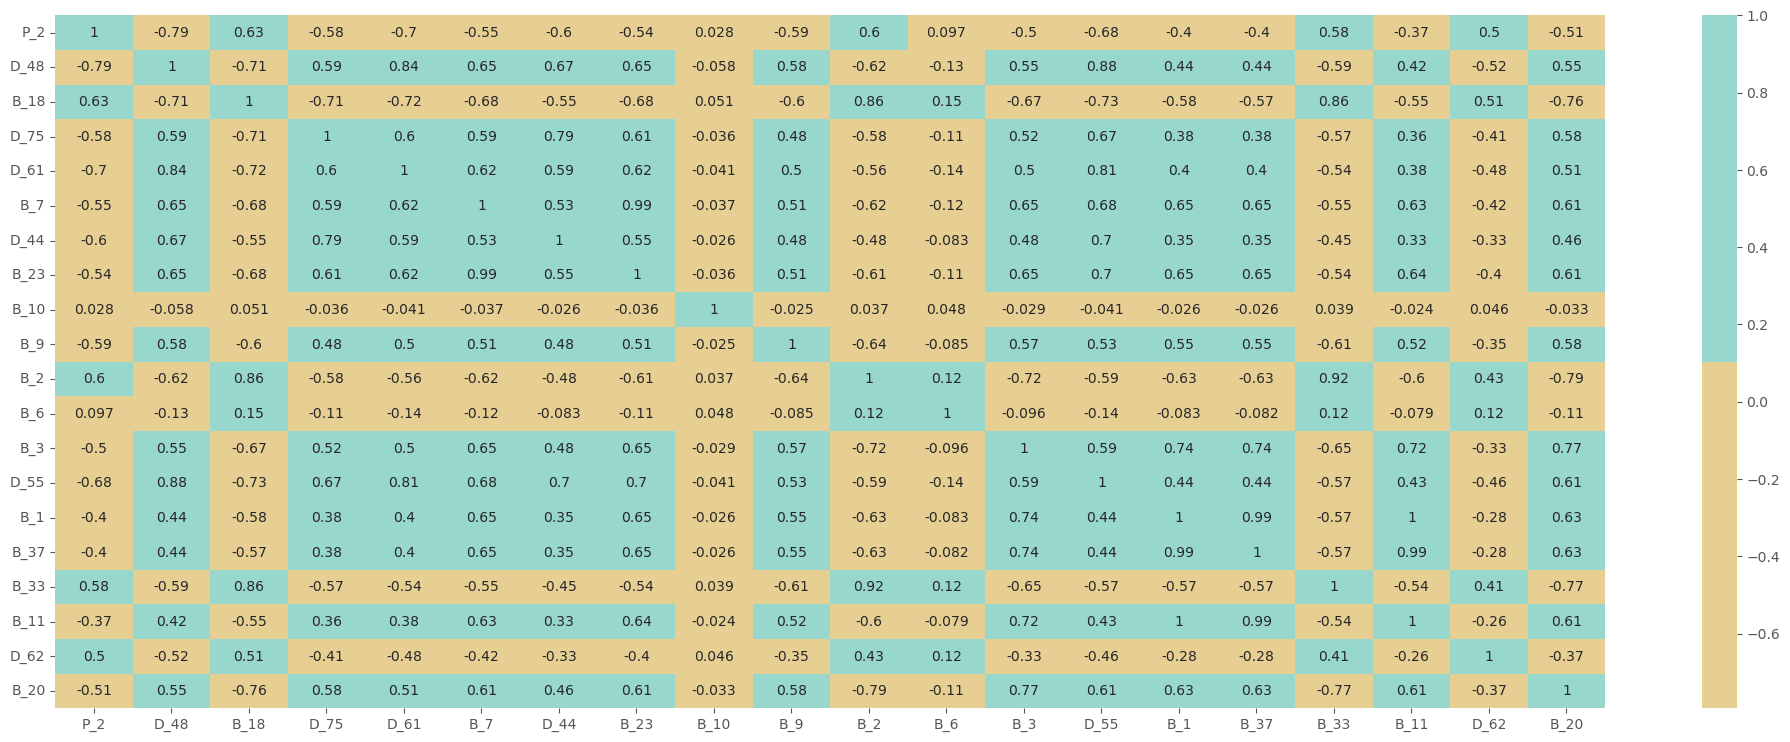

In [58]:
selected_features = iv_score_dataframe[iv_score_dataframe > 0.5].index.values  
cat_cols = [col for col in cat_cols if col in selected_features]  
train_cols = [col for col in train_dataframe.columns if col in selected_features] 

top_cols = [col for col in selected_features[:20] if col in train_cols]  
corr_df = train_dataframe[top_cols].corr()  
plt.figure(figsize=(25, 9))  
sns.heatmap(corr_df,annot=True ,cmap=sns.color_palette("BrBG",2));  
plt.show()  

In [59]:
def drop_feature_selection(row, col, corr, row_iv, col_iv):  
    if row_iv >= col_iv:  
        return col  
    else:  
        return row  
    
cor_matrix = train_dataframe[train_cols].corr().abs()  
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool_))  
corr_df = upper_tri.stack().reset_index()  
corr_df.columns = ['row', 'col', 'corr']  
corr_df = corr_df.drop_duplicates()  
corr_df = corr_df.sort_values('corr', ascending=False)  
corr_df = corr_df.query("corr >= 0.8")  
corr_df['row_iv'] = corr_df['row'].map(iv_score_dict)  
corr_df['col_iv'] = corr_df['col'].map(iv_score_dict)  
  
corr_df['drop_feature'] = corr_df.apply(lambda x: drop_feature_selection(x['row'], x['col'], x['corr'], x['row_iv'], x['col_iv']), axis=1)  
corr_df  

,row,col,corr,row_iv,col_iv,drop_feature
1432,D_62,D_77,0.999824,1.565751,1.144769,D_77
138,B_1,B_11,0.995629,1.688855,1.614301,B_11
850,B_7,B_23,0.994963,1.990450,1.940289,B_23
171,B_1,B_37,0.992982,1.688855,1.662309,B_37
1650,D_74,D_75,0.988533,1.508405,2.035478,D_74
1172,B_11,B_37,0.988209,1.614301,1.662309,B_11
1320,D_58,D_75,0.927898,1.445718,2.035478,D_58
1319,D_58,D_74,0.923637,1.445718,1.508405,D_58
223,B_2,B_33,0.918636,1.820367,1.638341,B_33
305,S_3,S_7,0.909011,0.933527,0.868302,S_7


In [60]:
corr_drop_features = corr_df['drop_feature'].unique().tolist() 

# train valid split  
train_data, valid_data = model_selection.train_test_split(train_dataframe, test_size=0.3, random_state=42, shuffle=True, stratify=train_dataframe['target'])  
train_data.shape, valid_data.shape 

selected_features = [col for col in selected_features if col not in corr_drop_features]  
cat_cols = [col for col in cat_cols if col in selected_features]  
train_cols = [col for col in train_dataframe.columns if col in selected_features]  

X_train = train_data[train_cols].copy()  
y_train = train_data[target_col].copy()  
  
X_valid = valid_data[train_cols].copy()  
y_valid = valid_data[target_col].copy()  
  
X_test = test_dataframe[train_cols].copy()  

### Mean Imputation of Blank Data

In [61]:
from sklearn.impute import SimpleImputer

# Initialize the imputer
imputer = SimpleImputer(strategy='mean')

# Impute missing values in X_train and X_valid
X_train = imputer.fit_transform(X_train)
X_valid = imputer.transform(X_valid)
X_test = imputer.transform(X_test)

## MACHINE LEARNING ALGORITHM - APPLICATION

### Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report


# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg.fit(X_train, y_train)

# Predict on the validation set
y_valid_pred = logreg.predict(X_valid)
y_valid_pred_proba = logreg.predict_proba(X_valid)[:, 1]

# Accuracy
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print(f'Validation Accuracy: {valid_accuracy:.4f}')

# ROC AUC Score
valid_roc_auc = roc_auc_score(y_valid, y_valid_pred_proba)
print(f'Validation ROC AUC: {valid_roc_auc:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_valid, y_valid_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report
class_report = classification_report(y_valid, y_valid_pred)
print('Classification Report:')
print(class_report)


Validation Accuracy: 0.8904
Validation ROC AUC: 0.9520
Confusion Matrix:
[[95587  6439]
 [ 8648 27000]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93    102026
           1       0.81      0.76      0.78     35648

    accuracy                           0.89    137674
   macro avg       0.86      0.85      0.85    137674
weighted avg       0.89      0.89      0.89    137674



### K Nearest Neighbor (KNN)

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Initialize the Logistic Regression model
knn_model = KNeighborsClassifier(n_neighbors=5) # generally k=5 is suitable to take decisions

# Train the model
knn_model.fit(X_train, y_train)

# Predict on the validation set
y_valid_pred = knn_model.predict(X_valid)
y_valid_pred_proba = knn_model.predict_proba(X_valid)[:, 1]

# Accuracy
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print(f'Validation Accuracy: {valid_accuracy:.4f}')

# ROC AUC Score
valid_roc_auc = roc_auc_score(y_valid, y_valid_pred_proba)
print(f'Validation ROC AUC: {valid_roc_auc:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_valid, y_valid_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report
class_report = classification_report(y_valid, y_valid_pred)
print('Classification Report:')
print(class_report)

Validation Accuracy: 0.8741
Validation ROC AUC: 0.9158
Confusion Matrix:
[[94839  7187]
 [10147 25501]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92    102026
           1       0.78      0.72      0.75     35648

    accuracy                           0.87    137674
   macro avg       0.84      0.82      0.83    137674
weighted avg       0.87      0.87      0.87    137674

